In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [59]:
data = pd.read_csv('diabetes.csv', header=None)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [60]:
print("Data shape:", X.shape)
print("Number of positive cases:", np.sum(y))
print("Number of negative cases:", len(y) - np.sum(y))

Data shape: (759, 8)
Number of positive cases: 496
Number of negative cases: 263


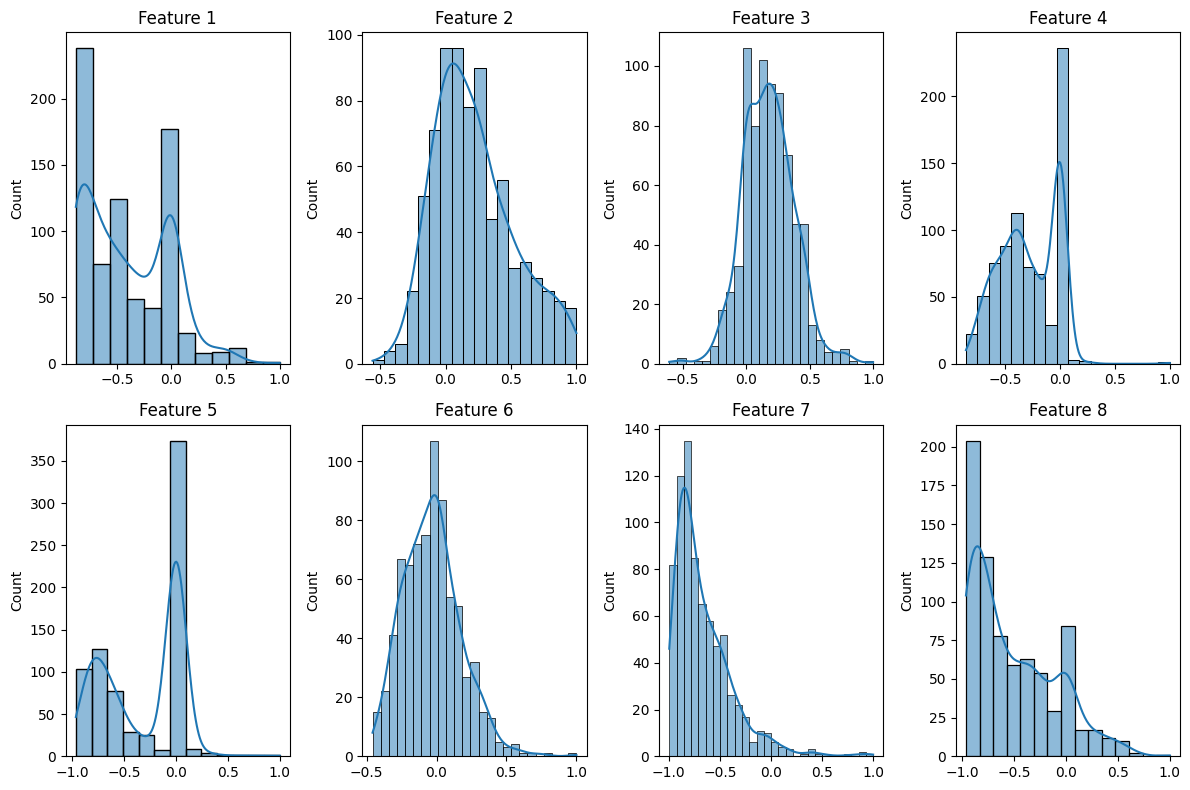

In [61]:
plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    sns.histplot(X[:, i], kde=True)
    plt.title(f'Feature {i+1}')
plt.tight_layout()
plt.show()

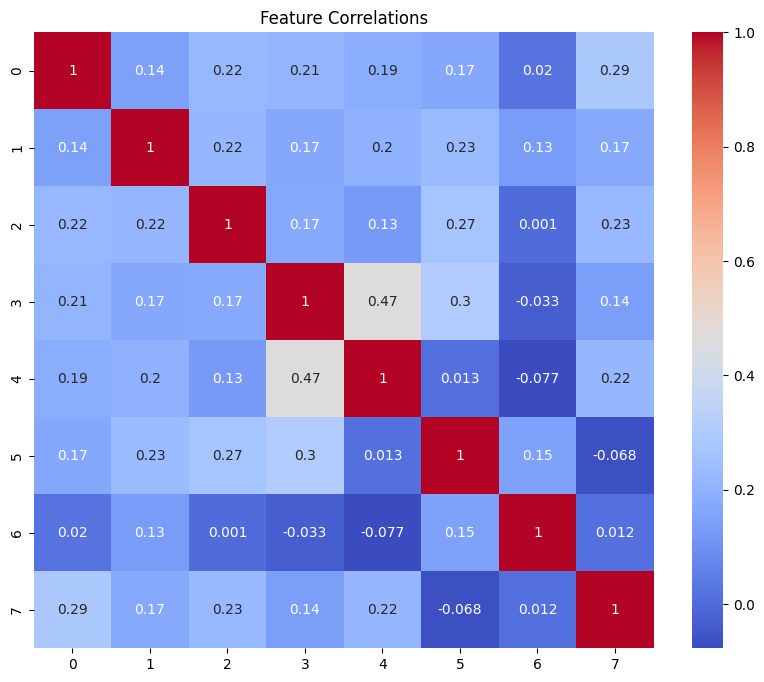

In [62]:
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(X).corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()

In [63]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [65]:
model = Sequential([
    Dense(16, activation='relu', input_shape=(8,)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

/Users/nikhilgudur/.pyenv/versions/3.11.0/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [66]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)


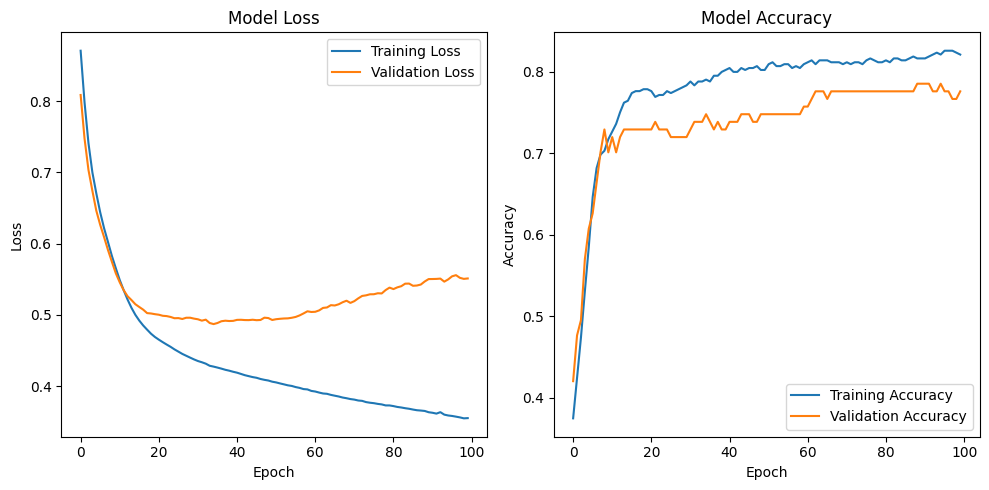

In [67]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [68]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

accuracy = np.mean(y_pred_classes == y_test)
print(f"Model accuracy: {accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model accuracy: 0.7675


Hypothesis 1: Increasing the model complexity by adding more layers and neurons might improve performance.
Hypothesis 2: Using dropout layers might help prevent overfitting and improve generalization.

In [69]:
model_complex = Sequential([
    Dense(32, activation='relu', input_shape=(8,)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_complex.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history_complex = model_complex.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)


In [70]:
model_dropout = Sequential([
    Dense(16, activation='relu', input_shape=(8,)),
    tf.keras.layers.Dropout(0.3),
    Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_dropout.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history_dropout = model_dropout.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

In [71]:
y_pred_complex = model_complex.predict(X_test)
y_pred_complex_classes = (y_pred_complex > 0.5).astype(int).flatten()
accuracy_complex = np.mean(y_pred_complex_classes == y_test)

y_pred_dropout = model_dropout.predict(X_test)
y_pred_dropout_classes = (y_pred_dropout > 0.5).astype(int).flatten()
accuracy_dropout = np.mean(y_pred_dropout_classes == y_test)

print(f"Original model accuracy: {accuracy:.4f}")
print(f"Complex model accuracy: {accuracy_complex:.4f}")
print(f"Dropout model accuracy: {accuracy_dropout:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Original model accuracy: 0.7675
Complex model accuracy: 0.6974
Dropout model accuracy: 0.7895


In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


In [73]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

In [74]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [75]:
class DiabetesModel(nn.Module):
    def __init__(self):
        super(DiabetesModel, self).__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [76]:
model = DiabetesModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [77]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

In [78]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_classes = (y_pred > 0.5).float().squeeze()
    accuracy = (y_pred_classes == y_test_tensor).float().mean()
    print(f"PyTorch model accuracy: {accuracy.item():.4f}")

PyTorch model accuracy: 0.7588


In [79]:
class ComplexDiabetesModel(nn.Module):
    def __init__(self):
        super(ComplexDiabetesModel, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

In [80]:
class DropoutDiabetesModel(nn.Module):
    def __init__(self):
        super(DropoutDiabetesModel, self).__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))
        return x

In [81]:
complex_model = ComplexDiabetesModel()
complex_optimizer = optim.Adam(complex_model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    complex_model.train()
    for inputs, labels in train_loader:
        complex_optimizer.zero_grad()
        outputs = complex_model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        complex_optimizer.step()

complex_model.eval()
with torch.no_grad():
    y_pred_complex = complex_model(X_test_tensor)
    y_pred_complex_classes = (y_pred_complex > 0.5).float().squeeze()
    accuracy_complex = (y_pred_complex_classes == y_test_tensor).float().mean()
    print(f"PyTorch complex model accuracy: {accuracy_complex.item():.4f}")


PyTorch complex model accuracy: 0.7588


In [82]:
dropout_model = DropoutDiabetesModel()
dropout_optimizer = optim.Adam(dropout_model.parameters(), lr=0.001)


for epoch in range(num_epochs):
    dropout_model.train()
    for inputs, labels in train_loader:
        dropout_optimizer.zero_grad()
        outputs = dropout_model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        dropout_optimizer.step()

dropout_model.eval()
with torch.no_grad():
    y_pred_dropout = dropout_model(X_test_tensor)
    y_pred_dropout_classes = (y_pred_dropout > 0.5).float().squeeze()
    accuracy_dropout = (y_pred_dropout_classes == y_test_tensor).float().mean()
    print(f"PyTorch dropout model accuracy: {accuracy_dropout.item():.4f}")

PyTorch dropout model accuracy: 0.7675


Discussion:
1. The TensorFlow and PyTorch models showed similar performance improvements with increased model complexity and regularization, achieving accuracies between 68% and 76%. 
2. PyTorch models slightly outperformed TensorFlow.